<a href="https://colab.research.google.com/github/valy3124/SupervisedLearning/blob/main/fmri_analysis_Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laborator 9 - Procesarea datelor de tip fMRI

Imagistica prin rezonanta magnetica functionala (fMRI) este o tehnica de neuroimagistica utilizata pentru a studia activitatea creierului prin masurarea schimbarilor in fluxul de sange oxigenat. Aceasta se bazeaza pe semnalul BOLD (Blood Oxygen Level Dependent), un semnal ce surprinde variatiile in nivelul de oxigenare a sangelui ca raspuns la activitatea neuronala. fMRI este o metoda non-invaziva, utilizata in diagnosticarea anumitor tulburari neurologice precum schizofrenie, ADHD sau bipolaritate.

Din punct de vedere programatic, datele de tip fMRI sunt 4D (volume 3D ale creierului, pe o perioada de timp). Acestea sunt obtinute fie in timp ce individul scanat este pus sa intreprinda o sarcina fie atunci cand acesta nu este conditionat de o activitate anume (resting state).

In cadrul acestui laborator veti invata cum sa vizualizati o astfel de imagine, care sunt pasii de preprocesare si cum pot fi ele folosite pentru detectia anumitor caracteristici ale pacientilor. De asemenea, va veti familiariza cu biblioteca Nilearn ce include multe functionalitati pentru procesare si vizualizare.

## Importări si constante

In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 12.1 MB/s eta 0:00:00


In [2]:
import random
from copy import deepcopy
import tqdm

import numpy as np
import pandas as pd
import nilearn
import matplotlib.pyplot as plt
from nilearn import datasets, plotting, image
from nilearn.input_data import NiftiLabelsMasker

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [3]:
# CONSTANTS

CONFOUND_COLS = ['csf', 'wm', 'global', 'motion-pitch', 'motion-roll', 'motion-yaw', 'motion-x', 'motion-y', 'motion-z']

## Set de date

In cadrul acestui laborator vom utiliza setul de date Nitrc ADHD resting-state dataset (https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_adhd.html), set ce contine atat subiecti sanatosi cat si diagnosticati cu ADHD. Numarul total de subiecti este de 40 (20 sanatosi, 20 cu ADHD).

Acest set de date se poate gasi in biblioteca Nilearn (folosind functia `datasets.fetch_adhd`. De asemenea, el este deja preprocesat cu tool-ul standard fMRIPrep ce aplica automat un set de preprocesari precum high-pass filtering, motion and slice-time corrections si multe altele. Acest pas este necesar pentru o evaluare corecta. Pentru cei ce doresc sa aprofundeze, puteti accesa link-ul urmator:
- https://fmriprep.org/en/stable/

Pentru laboratorul de astazi vom utiliza imaginile 4D impreuna cu confound-urile corespunzatoare fiecarei imagini (variabile ce sunt obtinute cu ajutorul fMRIPrep si care inglobeaza semnanele de origine non-neuronala folosite pentru un pas aditional de denoising).

In [4]:
adhd_dataset = datasets.fetch_adhd(n_subjects=40)

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/adhd

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7781/adhd40_metadata.tgz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7782/adhd40_0010042.tgz ...

[_chunk_report_] Downloaded 25755648 of 44414948 bytes (58.0%%,    0.7s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010042.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7783/adhd40_0010064.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010064.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7784/adhd40_0010128.tgz ...

[_chunk_report_] Downloaded 39632896 of 45461055 bytes (87.2%%,    0.1s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010128.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7785/adhd40_0021019.tgz ...

[_chunk_report_] Downloaded 33972224 of 46216320 bytes (73.5%%,    0.4s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0021019.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7786/adhd40_0023008.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0023008.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7787/adhd40_0023012.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0023012.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7788/adhd40_0027011.tgz ...

[_chunk_report_] Downloaded 28286976 of 72402326 bytes (39.1%%,    1.6s remaining)

[_chunk_report_] Downloaded 57262080 of 72402326 bytes (79.1%%,    0.5s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027011.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7789/adhd40_0027018.tgz ...

[_chunk_report_] Downloaded 28286976 of 76184603 bytes (37.1%%,    1.7s remaining)

[_chunk_report_] Downloaded 57352192 of 76184603 bytes (75.3%%,    0.7s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027018.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7790/adhd40_0027034.tgz ...

[_chunk_report_] Downloaded 27869184 of 70074120 bytes (39.8%%,    1.5s remaining)

[_chunk_report_] Downloaded 56868864 of 70074120 bytes (81.2%%,    0.5s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027034.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7791/adhd40_0027037.tgz ...

[_chunk_report_] Downloaded 28557312 of 69291635 bytes (41.2%%,    1.4s remaining)

[_chunk_report_] Downloaded 57524224 of 69291635 bytes (83.0%%,    0.4s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027037.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7792/adhd40_1019436.tgz ...

[_chunk_report_] Downloaded 28819456 of 41803342 bytes (68.9%%,    0.5s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1019436.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7793/adhd40_1206380.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1206380.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7794/adhd40_1418396.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1418396.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7795/adhd40_1517058.tgz ...

[_chunk_report_] Downloaded 28164096 of 62682233 bytes (44.9%%,    1.2s remaining)

[_chunk_report_] Downloaded 56991744 of 62682233 bytes (90.9%%,    0.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1517058.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7796/adhd40_1552181.tgz ...

[_chunk_report_] Downloaded 18202624 of 20196558 bytes (90.1%%,    0.1s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1552181.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7797/adhd40_1562298.tgz ...

[_chunk_report_] Downloaded 18202624 of 60663491 bytes (30.0%%,    2.4s remaining)

[_chunk_report_] Downloaded 37076992 of 60663491 bytes (61.1%%,    1.3s remaining)

[_chunk_report_] Downloaded 55951360 of 60663491 bytes (92.2%%,    0.3s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1562298.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7798/adhd40_1679142.tgz ...

[_chunk_report_] Downloaded 18333696 of 20628764 bytes (88.9%%,    0.1s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1679142.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7799/adhd40_2014113.tgz ...

[_chunk_report_] Downloaded 19906560 of 33119052 bytes (60.1%%,    0.7s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2014113.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7800/adhd40_2497695.tgz ...

[_chunk_report_] Downloaded 21766144 of 45455025 bytes (47.9%%,    1.1s remaining)

[_chunk_report_] Downloaded 45195264 of 45455025 bytes (99.4%%,    0.0s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2497695.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7801/adhd40_2950754.tgz ...

[_chunk_report_] Downloaded 24887296 of 57992968 bytes (42.9%%,    1.3s remaining)

[_chunk_report_] Downloaded 52420608 of 57992968 bytes (90.4%%,    0.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2950754.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7802/adhd40_3007585.tgz ...

[_chunk_report_] Downloaded 27639808 of 67925261 bytes (40.7%%,    1.5s remaining)

[_chunk_report_] Downloaded 55296000 of 67925261 bytes (81.4%%,    0.5s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3007585.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7803/adhd40_3154996.tgz ...

[_chunk_report_] Downloaded 28033024 of 32919780 bytes (85.2%%,    0.2s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3154996.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7804/adhd40_3205761.tgz ...

[_chunk_report_] Downloaded 27246592 of 59835286 bytes (45.5%%,    1.2s remaining)

[_chunk_report_] Downloaded 55558144 of 59835286 bytes (92.9%%,    0.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3205761.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7805/adhd40_3520880.tgz ...

[_chunk_report_] Downloaded 28557312 of 61857076 bytes (46.2%%,    1.2s remaining)

[_chunk_report_] Downloaded 57384960 of 61857076 bytes (92.8%%,    0.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3520880.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7806/adhd40_3624598.tgz ...

[_chunk_report_] Downloaded 28950528 of 59385206 bytes (48.8%%,    1.1s remaining)

[_chunk_report_] Downloaded 57778176 of 59385206 bytes (97.3%%,    0.1s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3624598.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7807/adhd40_3699991.tgz ...

[_chunk_report_] Downloaded 28483584 of 41518251 bytes (68.6%%,    0.5s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3699991.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7808/adhd40_3884955.tgz ...

[_chunk_report_] Downloaded 28557312 of 32108848 bytes (88.9%%,    0.1s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3884955.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7809/adhd40_3902469.tgz ...

[_chunk_report_] Downloaded 26935296 of 39415752 bytes (68.3%%,    0.5s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3902469.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7810/adhd40_3994098.tgz ...

[_chunk_report_] Downloaded 28286976 of 59297020 bytes (47.7%%,    1.1s remaining)

[_chunk_report_] Downloaded 57131008 of 59297020 bytes (96.3%%,    0.1s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3994098.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7811/adhd40_4016887.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4016887.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7812/adhd40_4046678.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4046678.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7813/adhd40_4134561.tgz ...

[_chunk_report_] Downloaded 27893760 of 69914913 bytes (39.9%%,    1.5s remaining)

[_chunk_report_] Downloaded 55812096 of 69914913 bytes (79.8%%,    0.5s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4134561.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7814/adhd40_4164316.tgz ...

[_chunk_report_] Downloaded 28426240 of 45506732 bytes (62.5%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4164316.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7815/adhd40_4275075.tgz ...

[_chunk_report_] Downloaded 28286976 of 32363673 bytes (87.4%%,    0.1s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4275075.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7816/adhd40_6115230.tgz ...

[_chunk_report_] Downloaded 28450816 of 73484949 bytes (38.7%%,    1.6s remaining)

[_chunk_report_] Downloaded 57262080 of 73484949 bytes (77.9%%,    0.6s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_6115230.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7817/adhd40_7774305.tgz ...

[_chunk_report_] Downloaded 28819456 of 42188959 bytes (68.3%%,    0.5s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_7774305.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7818/adhd40_8409791.tgz ...

[_chunk_report_] Downloaded 28680192 of 70396354 bytes (40.7%%,    1.5s remaining)

[_chunk_report_] Downloaded 57131008 of 70396354 bytes (81.2%%,    0.5s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_8409791.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7819/adhd40_8697774.tgz ...

[_chunk_report_] Downloaded 27500544 of 45075978 bytes (61.0%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_8697774.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7820/adhd40_9744150.tgz ...

[_chunk_report_] Downloaded 28164096 of 63380505 bytes (44.4%%,    1.3s remaining)

[_chunk_report_] Downloaded 57131008 of 63380505 bytes (90.1%%,    0.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_9744150.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7821/adhd40_9750701.tgz ...

[_chunk_report_] Downloaded 28426240 of 46607053 bytes (61.0%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_9750701.tgz...

[uncompress_file] .. done.

Obiectul intors contine:
- o lista de path-uri catre imaginile fMRI (`dataset['func']`)
- o lista de path-uri catre CSV-urile ce contin confounds-urile obtinute in urma analizei cu fMRIPrep (`dataset['confounds']`)
- o lista cu informatii legate de imaginile respective si despre subiectii in cauza (`dataset['phenotypic']`)

Pentru a obtine, de exemplu, id-ul subiectilor si etichetele (ADHD sau sanatos) putem rula urmatorul cod.

In [5]:
adhd_labels = [subject['adhd'] for subject in adhd_dataset['phenotypic']]
subject_ids = [subject[1] for subject in adhd_dataset['phenotypic']]

print("Subject IDs:", subject_ids)
print("ADHD Labels for subjects:", adhd_labels)

Subject IDs: [10042, 10064, 10128, 21019, 23008, 23012, 27011, 27018, 27034, 27037, 1019436, 1206380, 1418396, 1517058, 1552181, 1562298, 1679142, 2014113, 2497695, 2950754, 3007585, 3154996, 3205761, 3520880, 3624598, 3699991, 3884955, 3902469, 3994098, 4016887, 4046678, 4134561, 4164316, 4275075, 6115230, 7774305, 8409791, 8697774, 9744150, 9750701]
ADHD Labels for subjects: [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


## Vizualizarea datelor

Pentru a intelege cum arata o imagine de tip fMRI, putem folosi functiile puse la dispozitie de Nilearn pentru incarcare si afisare.

(61, 73, 61, 176)
(61, 73, 61, 175)


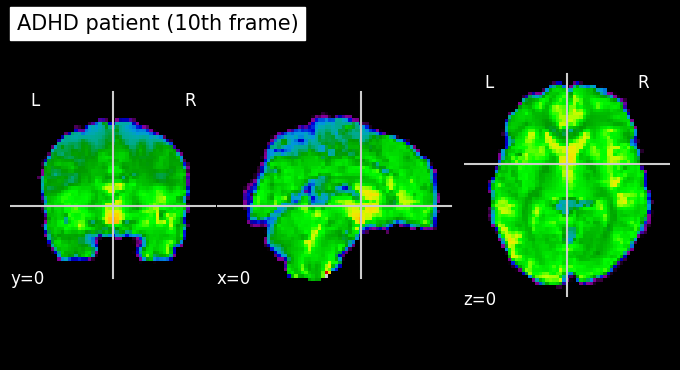

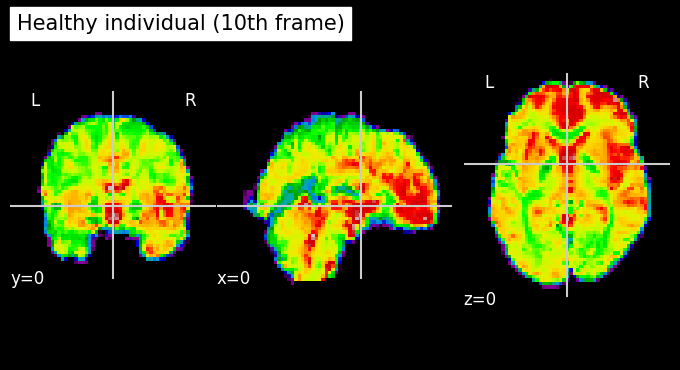

In [6]:
adhd_sub = image.load_img(adhd_dataset['func'][0])
healthy_sub = image.load_img(adhd_dataset['func'][3])
print(adhd_sub.shape)
print(healthy_sub.shape)

plotting.plot_epi(adhd_sub.slicer[:, :, :, 10], cut_coords=(0, 0, 0), title="ADHD patient (10th frame)")
plotting.plot_epi(healthy_sub.slicer[:, :, :, 10], cut_coords=(0, 0, 0), title="Healthy individual (10th frame)")

<ipython-input-7-80b48d8fc550>:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.plot_epi(image.mean_img(adhd_sub), cut_coords=(0, 0, 0), title="ADHD patient (Average over time dimension)")
<ipython-input-7-80b48d8fc550>:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.plot_epi(image.mean_img(healthy_sub), cut_coords=(0, 0, 0), title="Healthy individual (Average over time dimension)")


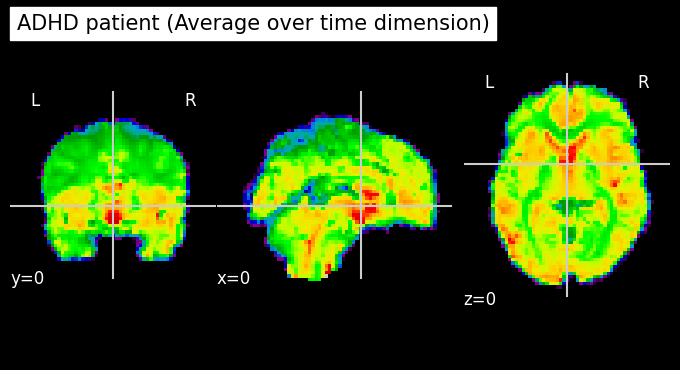

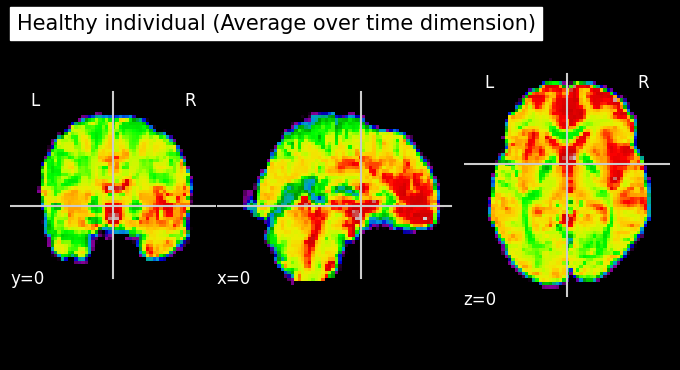

In [7]:
plotting.plot_epi(image.mean_img(adhd_sub), cut_coords=(0, 0, 0), title="ADHD patient (Average over time dimension)")
plotting.plot_epi(image.mean_img(healthy_sub), cut_coords=(0, 0, 0), title="Healthy individual (Average over time dimension)")

Putem observa zone de culori diferite. Culorile mai deschise (spre rosu) au un raspuns mai puternic adica o cantitate mai mare de sange oxigenat ceea ce reprezinta o activitate neuronala mai intensa fata de zonele mai inchise (spre albastru).

TODO 1: Alegeti un subiect random, iar pentru acesta alegeti un volum 3D (frame) random din seria temporala si afisati-l.

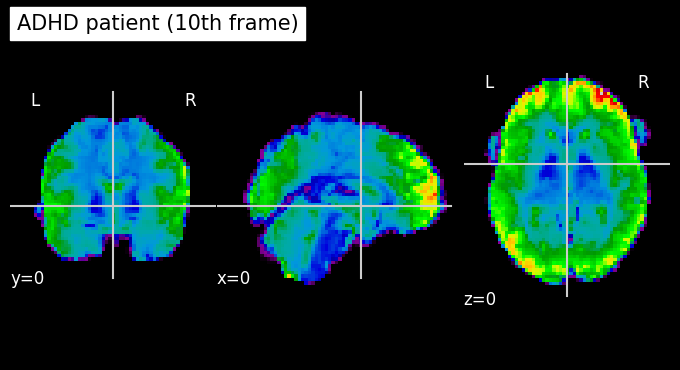

In [8]:
# TODO 1: Alegeti un subiect random, iar pentru acesta alegeri un volum 3D (frame) random din seria temporala si afisati-l
adhd_sub1 = image.load_img(adhd_dataset['func'][10])

plotting.plot_epi(adhd_sub1.slicer[:, :, :, 10], cut_coords=(0, 0, 0), title="ADHD patient (10th frame)")

## Pre-procesare

Desi imaginile functionale sunt destul de expresive din punct de vedere vizual, ele pot fi reduse intr-o forma mai compacta pentru a fi utilizate in antrenarea modelelor supervizate.

Pentru aceasta, putem aplica "atlase functionale ale creierului" (FBNs). Un atlas functional este, in fapt, un set de masti 3D, cate o masca pentru o regiune functionala de interes, ce poate fi aplicata pe fiecare volum 3D din seria temporala pentru a obtine un singur numar ce reprezinta gradul de activare a respectivei zone la acel moment de timp. Aceste zone functionale de interes sunt desprinse din fiziologia creierului, o zona ocupandu-se cu o anumita sarcina (ex: centrii vizuali, motorii, ai controlului etc.)

Astfel, dupa aplicarea unui atlas functional, imaginea 4D (x, y, z, t) este redusa la un set de serii temporale ce iau forma unei matrice 2D (t, k) unde t reprezinta coordonata temporala, iar k reprezinta numarul de astfel de zone predefinite.

De asemenea, in acest pas putem aplica si pasul aditional de denoising folosind confound-urile despre care am vorbit anterior.

In [9]:
# Incarcare confounds
confounds = pd.read_csv(adhd_dataset['confounds'][0], sep='\t', usecols=CONFOUND_COLS)
confounds = confounds.values

[get_dataset_dir] Dataset created in /root/nilearn_data/yeo_2011

[fetch_single_file] Downloading data from ftp://surfer.nmr.mgh.harvard.edu/pub/data/Yeo_JNeurophysiol11_MNI152.zip 
...

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/yeo_2011/622858b56913b19ae0865d9fa8ad47cc/Yeo_JNeurophysiol11_MNI152.zip...

[uncompress_file] .. done.

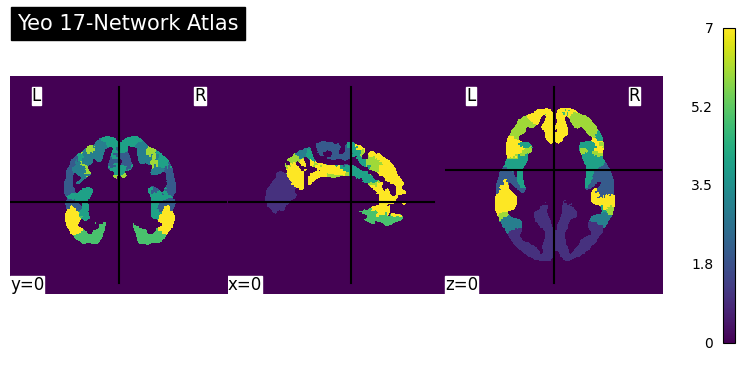

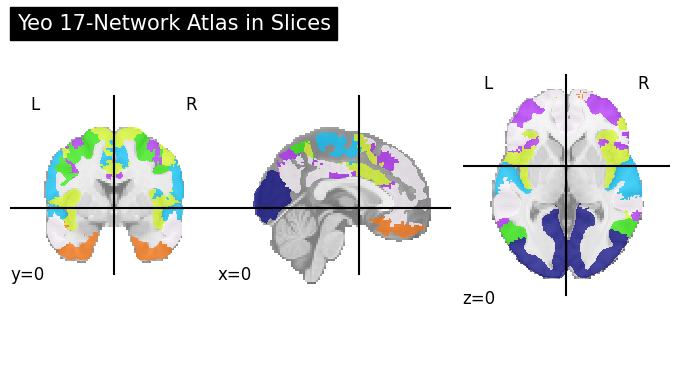

In [10]:
# Incarcare si plot atlas functional Yeo-17

#atlas = image.load_img(nilearn.datasets.fetch_atlas_yeo_2011()['thick_17'])
atlas = image.load_img(nilearn.datasets.fetch_atlas_yeo_2011()['thick_7'])  # Changed to Yeo-7
plotting.plot_img(atlas, cut_coords=(0, 0, 0), title="Yeo 17-Network Atlas", colorbar=True)
plotting.plot_roi(atlas, cut_coords=(0, 0, 0), title="Yeo 17-Network Atlas in Slices")

In [11]:
# Aplicarea pasului de curatare si a atlasului functional

masker = NiftiLabelsMasker(labels_img=atlas, standardize=True, detrend=True)
cleaned_img = masker.fit_transform(adhd_sub, confounds)
print(adhd_sub.shape)
print(cleaned_img.shape)  # (X, Y, Z, T) -> (T, K)

(61, 73, 61, 176)
(176, 7)


TODO 2: Trasati pe acelasi grafic folosind matplotlib primele 5 semnale din cele 17 obtinute

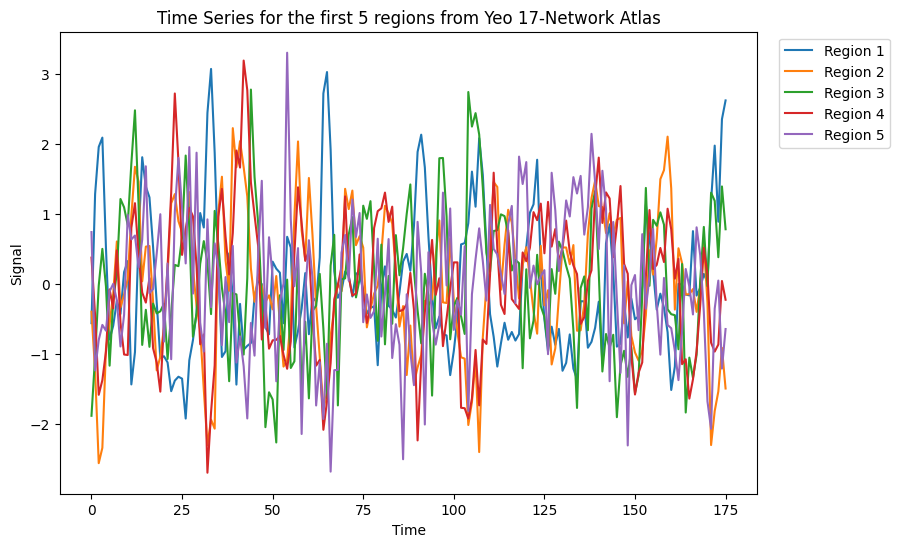

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(9, 6))

for i in range(5):
    # TODO 2: Apelati functia de plot pentru fiecare serie temporala (folosind indexul 'i')
    plt.plot(cleaned_img[:, i], label=f'Region {i + 1}')

plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Time Series for the first 5 regions from Yeo 17-Network Atlas')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()
plt.clf()

## Antrenare

Dorim sa antrenam un simplu 1D CNN pentru clasificare (ADHD sau sanatos).


In [13]:
# Preprocesarea intregului set de date

subject_images = []
subject_labels = []
#atlas = image.load_img(nilearn.datasets.fetch_atlas_yeo_2011()['thick_17'])  # Hint 1
atlas = image.load_img(nilearn.datasets.fetch_atlas_yeo_2011()['thick_7'])

for confound_filename, img_filename, info in tqdm.tqdm(zip(adhd_dataset['confounds'], adhd_dataset['func'], adhd_dataset['phenotypic'])):
    confounds = pd.read_csv(confound_filename, sep='\t', usecols=CONFOUND_COLS)
    confounds = confounds.values

    img = image.load_img(img_filename)
    masker = NiftiLabelsMasker(labels_img=deepcopy(atlas), standardize=True, detrend=True)
    cleaned_img = masker.fit_transform(img, confounds)

    subject_images.append(cleaned_img)
    subject_labels.append(info['adhd'])

[get_dataset_dir] Dataset found in /root/nilearn_data/yeo_2011

40it [04:03,  6.09s/it]


In [14]:
print(len(subject_images))
print(subject_images[0].shape)
print(subject_labels)

40
(176, 7)
[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


In [15]:
# Set random seeds
torch.manual_seed(40)
np.random.seed(40)
random.seed(40)

# For CUDA (GPU)
torch.cuda.manual_seed_all(40)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
X_train, X_test, y_train, y_test = train_test_split(subject_images, subject_labels, test_size=10/40, stratify=subject_labels, random_state=42)


class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return np.transpose(self.data[idx]), self.labels[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Create DataLoaders
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
class CNN1D(nn.Module):
    def __init__(self, num_features=17, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Output size (batch_size, channels, 1)
        self.fc = nn.Linear(64, num_classes)  # 64 is the number of channels after conv layers

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.global_pool(x)  # (batch_size, channels, 1)
        x = x.squeeze(-1)  # Remove the last dimension: (batch_size, channels)
        x = self.fc(x)  # Fully connected layer for classification
        return x

In [18]:
'''
class CNN1D(nn.Module):
    def __init__(self, num_features=17, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3)
        # Remove bn1: self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        # Remove bn2: self.bn2 = nn.BatchNorm1d(64)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x)) # Remove bn1
        x = torch.relu(self.conv2(x)) # Remove bn2
        x = self.global_pool(x)
        x = x.squeeze(-1)
        x = self.fc(x)
        return x
'''

'\nclass CNN1D(nn.Module):\n    def __init__(self, num_features=17, num_classes=2):\n        super().__init__()\n        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3)\n        # Remove bn1: self.bn1 = nn.BatchNorm1d(32)\n        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)\n        # Remove bn2: self.bn2 = nn.BatchNorm1d(64)\n        self.global_pool = nn.AdaptiveAvgPool1d(1) \n        self.fc = nn.Linear(64, num_classes)\n\n    def forward(self, x):\n        x = torch.relu(self.conv1(x)) # Remove bn1\n        x = torch.relu(self.conv2(x)) # Remove bn2\n        x = self.global_pool(x)\n        x = x.squeeze(-1)\n        x = self.fc(x)\n        return x\n'

100%|██████████| 250/250 [00:17<00:00, 14.09it/s]


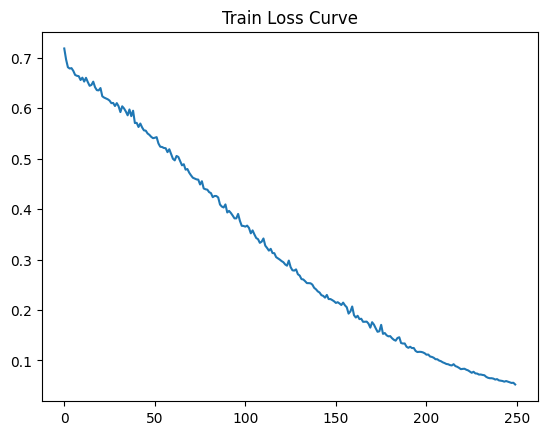

<Figure size 640x480 with 0 Axes>

In [19]:
#model = CNN1D(num_features=17, num_classes=2)  # Hint 2.
model = CNN1D(num_features=7, num_classes=2)  # Changed num_features to 7
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

# Training loop
num_epochs = 250
for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    losses.append(train_loss / len(train_loader))

plt.plot(losses)
plt.title("Train Loss Curve")
plt.show()
plt.clf()

In [20]:
# Evaluate on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        outputs = model(batch_data)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 60.00%


TODO 3: Incercati aceeasi antrenare fara batchnorm. Ce observati legat de graficul loss-ului de antrenare?

TODO 4: Adaugati batchnorm-urile acolo unde se aflau anterior. Incercati o alta varianta a atlasului functional yeo (yeo-7, yeo-17 thin etc.) (https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_atlas_yeo_2011.html)

Hint 1: modificat in celula ce preproceseaza intreg setul de date (prima celulta din categoria "Antrenare").

Hint 2: atunci cand alegeti o varianta precum yeo-7 trebuie tinut cont de faptul ca numarul feature-urilor nu va mai fi 17 ci 7 (celula ce contine codul de antrenare).

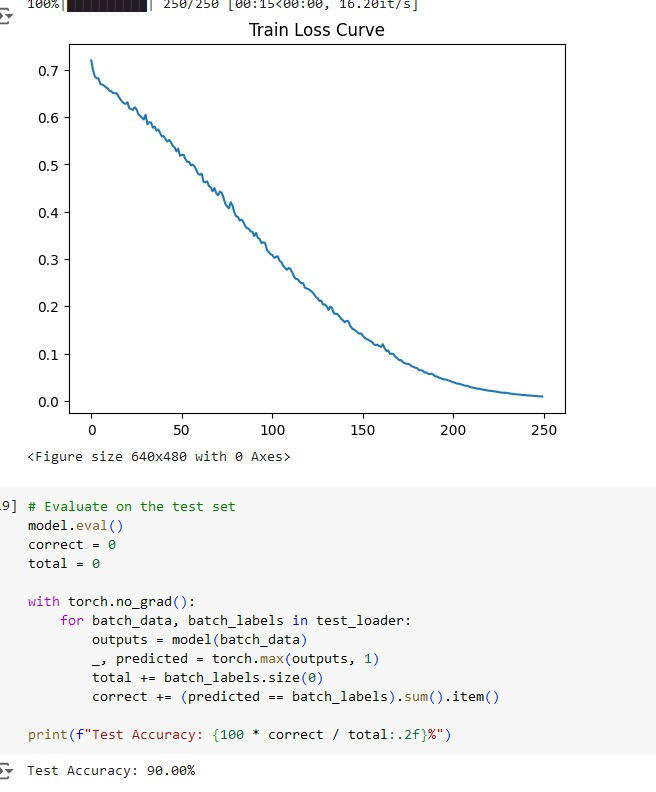

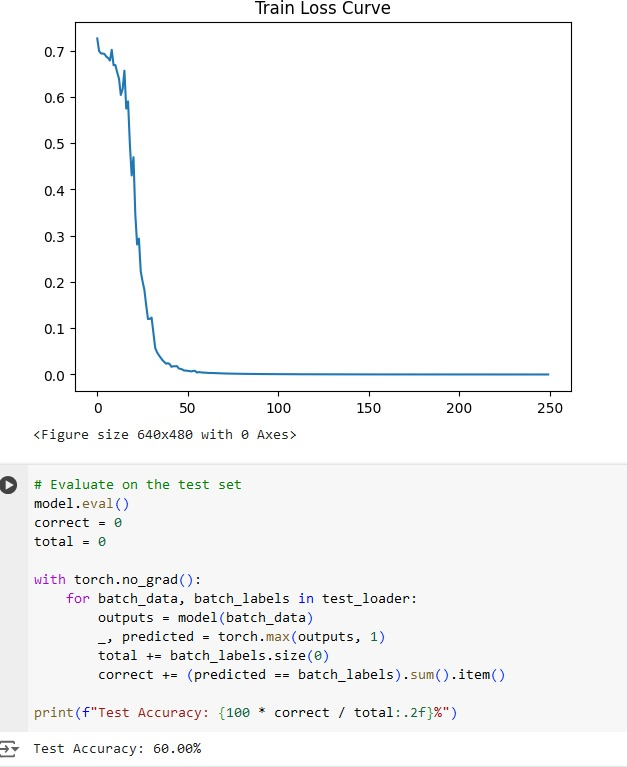

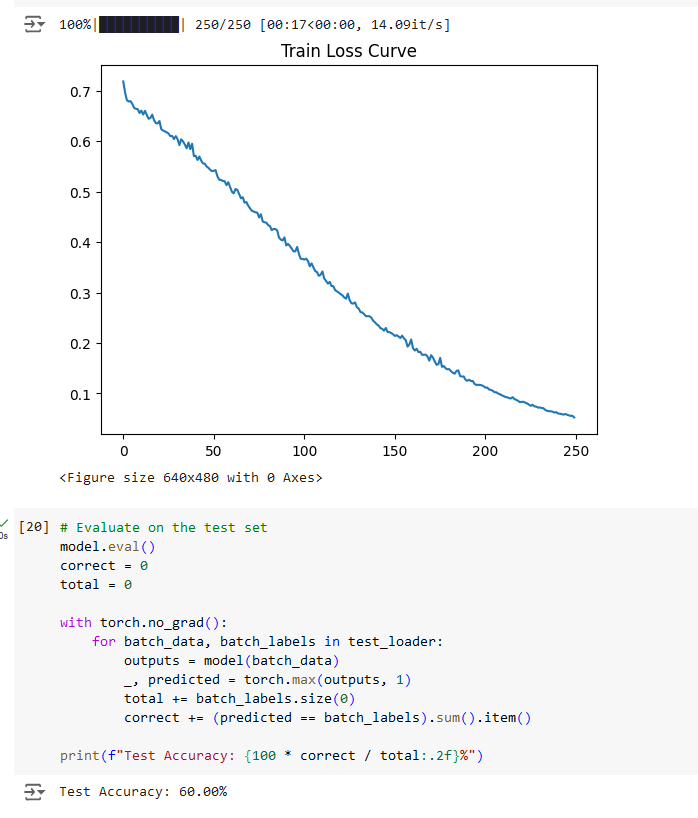